In [1]:
def createDataSet():
    dataSet=[[1,1,'yes'],[1,1,'yes'],[1,0,'no'],[0,1,'no'],[0,1,'no']]
    labels=['no surfacing','flippers']
    return dataSet,labels

In [2]:
myDat,labels = createDataSet()
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [27]:
from math import log

def calcShannonEnt(dataSet):
    numEntries = len(dataSet) #nrows
    #为所有的分类类目创建字典
    labelCounts ={}
    for featVec in dataSet:
        currentLable=featVec[-1] #取得最后一列数据
        if currentLable not in labelCounts.keys():
            labelCounts[currentLable]=0
        labelCounts[currentLable]+=1
    #计算香农熵
    shannonEnt=0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

In [28]:
calcShannonEnt(myDat)#利用构造的数据测试calcShannonEnt：

0.9709505944546686

In [5]:
#定义按照某个特征进行划分的函数splitDataSet
#输入三个变量（待划分的数据集，特征，分类值）
def splitDataSet(dataSet,axis,value):
    retDataSet=[]
    for featVec in dataSet:
        if featVec[axis]==value : 
            reduceFeatVec=featVec[:axis]
            reduceFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reduceFeatVec)
    return retDataSet #返回不含划分特征的子集

#定义按照最大信息增益划分数据的函数
def chooseBestFeatureToSplit(dataSet):
    numFeature=len(dataSet[0])-1
    baseEntropy=calcShannonEnt(dataSet)#香农熵
    bestInforGain=0
    bestFeature=-1
    for i in range(numFeature):
        featList=[number[i] for number in dataSet] #得到某个特征下所有值（某列）
        uniqualVals=set(featList) #set无重复的属性特征值
        newEntropy=0
        for value in uniqualVals:
            subDataSet=splitDataSet(dataSet,i,value)
            prob=len(subDataSet)/float(len(dataSet)) #即p(t)
            newEntropy+=prob*calcShannonEnt(subDataSet)#对各子集香农熵求和
        infoGain=baseEntropy-newEntropy #计算信息增益
        #最大信息增益
        if (infoGain>bestInforGain):
            bestInforGain=infoGain
            bestFeature=i
    return bestFeature #返回特征值

In [6]:
myDat,labels=createDataSet()
splitDataSet(myDat,0,0)

[[1, 'no'], [1, 'no']]

In [7]:
splitDataSet(myDat,0,1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [8]:
chooseBestFeatureToSplit(myDat)

0

In [9]:
#投票表决代码
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys():classCount[vote]=0
        classCount[vote]+=1
    sortedClassCount=sorted(classCount.items,key=operator.itemgetter(1),reversed=True)
    return sortedClassCount[0][0]

def createTree(dataSet,labels):
    classList=[example[-1] for example in dataSet]
    #类别相同，停止划分
    if classList.count(classList[-1])==len(classList):
        return classList[-1]
    #长度为1，返回出现次数最多的类别
    if len(classList[0])==1:
        return majorityCnt(classList)
    #按照信息增益最高选取分类特征属性
    bestFeat=chooseBestFeatureToSplit(dataSet)#返回分类的特征序号
    bestFeatLable=labels[bestFeat] #该特征的label
    myTree={bestFeatLable:{}} #构建树的字典
    del(labels[bestFeat]) #从labels的list中删除该label
    featValues=[example[bestFeat] for example in dataSet]
    uniqueVals=set(featValues)
    for value in uniqueVals:
        subLables=labels[:] #子集合
        #构建数据的子集合，并进行递归
        myTree[bestFeatLable][value]=createTree(splitDataSet(dataSet,bestFeat,value),subLables)
    return myTree

In [10]:
myTree=createTree(myDat,labels)

In [11]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [12]:
#输入三个变量（决策树，属性特征标签，测试的数据）
def classify(inputTree,featLables,testVec):
    firstStr=list(inputTree.keys())[0] #获取树的第一个特征属性
    secondDict=inputTree[firstStr] #树的分支，子集合Dict
    featIndex=featLables.index(firstStr) #获取决策树第一层在featLables中的位置
    for key in secondDict.keys():
        if testVec[featIndex]==key:
            if type(secondDict[key]).__name__=='dict':
                classLabel=classify(secondDict[key],featLables,testVec)
            else:classLabel=secondDict[key]
    return classLabel

In [13]:
##存储决策树
def storeTree(inputTree,filename):
    import pickle
    fw=open(filename,'wb') #pickle默认方式是二进制，需要制定'wb'
    pickle.dump(inputTree,fw)
    fw.close()

In [14]:
#读取决策树
def grabTree(filename):
    import pickle
    fr=open(filename,'rb')#需要制定'rb'，以byte形式读取
    return pickle.load(fr)

In [15]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [16]:
storeTree(myTree,'classifierStorage.txt')

In [17]:
grabTree('classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [18]:
##绘制决策树图
import matplotlib.pyplot as plt

from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei'] #否则中文无法正常显示

decisionNode=dict(boxstyle='sawtooth',fc='0.8') #决策点样式
leafNode=dict(boxstyle='round4',fc='0.8')#叶节点样式
arrow_args=dict(arrowstyle='<-') #箭头样式

def plotNode(nodeTxt,centerPt,parentPt,nodeType):
    createPlot.ax1.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',
                            xytext=centerPt,textcoords='axes fraction',
                            va='center',ha='center',bbox=nodeType,arrowprops=arrow_args)

def createPlot():
    fig=plt.figure(1,facecolor='white')
    fig.clf()
    createPlot.ax1=plt.subplot(111,frameon=False)
    plotNode('决策节点',(0.5,0.1),(0.1,0.5),decisionNode)
    plotNode('叶节点',(0.8,0.1),(0.3,0.8),leafNode)
    plt.show()

#测试
#获取叶节点数量（广度）
def getNumLeafs(myTree):
    numLeafs=0
    firstStr=list(myTree.keys())[0]#'dict_keys' object does not support indexing
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs+=getNumLeafs(secondDict[key])
        else:numLeafs+=1
    return numLeafs

#获取树的深度的函数（深度）
def getTreeDepth(myTree):
    maxDepth=0
    firstStr=list(myTree.keys())[0]
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth=1+getTreeDepth(secondDict[key])
        else: thisDepth=1
        if thisDepth > maxDepth:
            maxDepth=thisDepth
    return maxDepth
#定义一个预先创建树的函数
def retrieveTree(i):
    listOfTrees=[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                 {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head':{0:'no', 1: 'yes'}},1:'no'}}}}
                 ]
    return listOfTrees[i]

#定义在父子节点之间填充文本信息的函数
def plotMidText(cntrPt,parentPt,txtString):
    xMid=(parentPt[0]-cntrPt[0])/2+cntrPt[0]
    yMid=(parentPt[1]-cntrPt[1])/2+cntrPt[1]
    createPlot.ax1.text(xMid,yMid,txtString)

#定义树绘制的函数    
def plotTree(myTree,parentPt,nodeTxt):
    numLeafs=getNumLeafs(myTree)
    depth=getTreeDepth(myTree)
    firstStr=list(myTree.keys())[0]
    cntrPt=(plotTree.xOff+(1.0+float(numLeafs))/2/plotTree.totalW,plotTree.yOff)
    plotMidText(cntrPt,parentPt,nodeTxt)
    plotNode(firstStr,cntrPt,parentPt,decisionNode)
    secondDict=myTree[firstStr]
    plotTree.yOff=plotTree.yOff -1/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff=plotTree.xOff+1.0/plotTree.totalW
            plotNode(secondDict[key],(plotTree.xOff,plotTree.yOff),cntrPt,leafNode)
            plotMidText((plotTree.xOff,plotTree.yOff),cntrPt,str(key))
    plotTree.yOff=plotTree.yOff+1/plotTree.totalD

 #定义主函数，来调用其它函数   
def createPlot(inTree):
    fig=plt.figure(1,facecolor='white')
    fig.clf()
    axprops=dict(xticks=[],yticks=[])
    createPlot.ax1=plt.subplot(111,frameon=False,**axprops)
    plotTree.totalW=float(getNumLeafs(inTree))
    plotTree.totalD=float(getTreeDepth(inTree))
    plotTree.xOff=-0.5/plotTree.totalW;plotTree.yOff=1.0;
    plotTree(inTree,(0.5,1.0),'')
    plt.show()

In [19]:
myTree = retrieveTree(0)

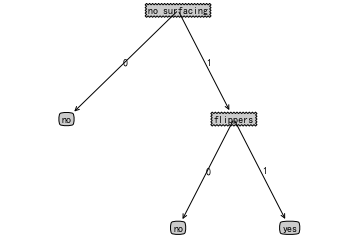

In [20]:
createPlot(myTree)

In [21]:
##测试实例
fr=open('lenses.txt')

In [22]:
lenses=[inst.strip().split() for inst in fr.readlines()]

In [23]:
lensesLabels=['age','prescript','astigmatic','tearRate']

In [24]:
lenses

[['young', 'myope', 'no', 'reduced', 'nolenses'],
 ['young', 'myope', 'no', 'normal', 'soft'],
 ['young', 'myope', 'yes', 'reduced', 'nolenses'],
 ['young', 'myope', 'yes', 'normal', 'hard'],
 ['young', 'hyper', 'no', 'reduced', 'nolenses'],
 ['young', 'hyper', 'no', 'normal', 'soft'],
 ['young', 'hyper', 'yes', 'reduced', 'nolenses'],
 ['young', 'hyper', 'yes', 'normal', 'hard'],
 ['pre', 'myope', 'no', 'reduced', 'nolenses'],
 ['pre', 'myope', 'no', 'normal', 'soft'],
 ['pre', 'myope', 'yes', 'reduced', 'nolenses'],
 ['pre', 'myope', 'yes', 'normal', 'hard'],
 ['pre', 'hyper', 'no', 'reduced', 'nolenses'],
 ['pre', 'hyper', 'no', 'normal', 'soft'],
 ['pre', 'hyper', 'yes', 'reduced', 'nolenses'],
 ['pre', 'hyper', 'yes', 'normal', 'nolenses'],
 ['presbyopic', 'myope', 'no', 'reduced', 'nolenses'],
 ['presbyopic', 'myope', 'no', 'normal', 'nolenses'],
 ['presbyopic', 'myope', 'yes', 'reduced', 'nolenses'],
 ['presbyopic', 'myope', 'yes', 'normal', 'hard'],
 ['presbyopic', 'hyper', 'no

In [29]:
lensesTree=createTree(lenses,lensesLabels)

In [30]:
lensesTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'nolenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'nolenses',
        'presbyopic': 'nolenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'nolenses'}}

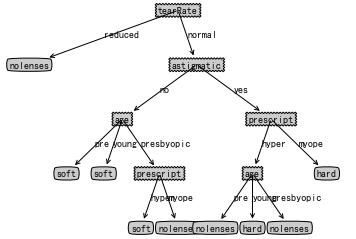

In [31]:
createPlot(lensesTree)